In [42]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score,RepeatedStratifiedKFold,GridSearchCV,cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [43]:
df = pd.read_csv('SA heart.csv')

In [44]:
df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


# Question 2

## (a) Build a logistic regression model to predict the probability of getting CHD

In [45]:
X = df.drop(['row.names','chd'],axis = 1)
y = df.chd

In [46]:
df['chd'].value_counts()

0    302
1    160
Name: chd, dtype: int64

In [47]:
X_trn,X_val,y_trn,y_val = train_test_split(X,y,test_size = .23,stratify = y)

In [48]:
le = sklearn.preprocessing.LabelEncoder()

In [49]:
X_val['famhist'].unique()

array(['Absent', 'Present'], dtype=object)

In [50]:
X_trn.loc[:,'famhist'] = le.fit_transform(X_trn['famhist'])

In [51]:
X_val.loc[:,'famhist'] = le.transform(X_val['famhist']) 

In [52]:
rs = RobustScaler() 

In [53]:
X_trn_rs = rs.fit_transform(X_trn)
X_val_rs = rs.transform(X_val)

In [54]:
logreg = LogisticRegression()
logreg.fit(X_trn_rs,y_trn)
model = LogisticRegression()

In [55]:
print("ACCURACY      :",np.round(cross_validate(model,X_trn_rs,y_trn,cv=7)['test_score'].mean()*100,2))
print("ROC AUC SCORE :",np.round(cross_val_score(model, X_trn_rs, y_trn, scoring="roc_auc", cv = 7).mean()*100,2))

ACCURACY      : 71.27
ROC AUC SCORE : 76.17


## i.	Find out which features are statistically significant in the logistic regression model built in (a).

In [56]:
import statsmodels.api as sm 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [57]:
# Adding the column of ones so it can provide intercept.
XX_trn = sm.add_constant(X_trn)
XXX_trn = sm.add_constant(X_trn)
model=sm.Logit(y_trn,XX_trn,random_state=0)
result0=model.fit()
print(result0.summary())

Optimization terminated successfully.
         Current function value: 0.515011
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  355
Model:                          Logit   Df Residuals:                      345
Method:                           MLE   Df Model:                            9
Date:                Thu, 03 Dec 2020   Pseudo R-squ.:                  0.2018
Time:                        17:35:38   Log-Likelihood:                -182.83
converged:                       True   LL-Null:                       -229.06
Covariance Type:            nonrobust   LLR p-value:                 5.212e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8595      1.489     -3.936      0.000      -8.777      -2.942
sbp            0.0040      0.

## ii.	Build a new logistic regression model using only significant features.

Below Code automatically detects p values greater than 0.05 and removes them and does this step by step

In [58]:
for _ in range(11):
  model=sm.Logit(y_trn,XX_trn,random_state=0)
  result=model.fit()
  print(result.summary())
  p = pd.DataFrame(result.pvalues)
  p.columns = ['p_vals']
  shit = np.argmax(p['p_vals'])
  #print(shit,max((p['p_vals']))) 
  #XX_trn = XX_trn.drop([shit],axis = 1)
  XX_trn = XX_trn.drop(XX_trn.columns[shit], axis=1)
  if max(p.values) < .051:
    break 

Optimization terminated successfully.
         Current function value: 0.515011
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  355
Model:                          Logit   Df Residuals:                      345
Method:                           MLE   Df Model:                            9
Date:                Thu, 03 Dec 2020   Pseudo R-squ.:                  0.2018
Time:                        17:35:38   Log-Likelihood:                -182.83
converged:                       True   LL-Null:                       -229.06
Covariance Type:            nonrobust   LLR p-value:                 5.212e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8595      1.489     -3.936      0.000      -8.777      -2.942
sbp            0.0040      0.

In [59]:
p.index

Index(['const', 'tobacco', 'ldl', 'famhist', 'typea', 'age'], dtype='object')

In [60]:
stat_signi = p.index

In [61]:
model=sm.Logit(y_trn,XXX_trn[stat_signi],random_state=0)
result1=model.fit()
print(result1.summary())
print(result1.aic)

Optimization terminated successfully.
         Current function value: 0.517751
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  355
Model:                          Logit   Df Residuals:                      349
Method:                           MLE   Df Model:                            5
Date:                Thu, 03 Dec 2020   Pseudo R-squ.:                  0.1976
Time:                        17:35:38   Log-Likelihood:                -183.80
converged:                       True   LL-Null:                       -229.06
Covariance Type:            nonrobust   LLR p-value:                 5.232e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.3745      1.068     -5.968      0.000      -8.468      -4.281
tobacco        0.0777      0.

In [62]:
print('Is the model with Significant estimators better?',result.aic < result0.aic) #this model is better as it has lower AIC than the model with all predictors 
#print(result.aic,result0.aic)

Is the model with Significant estimators better? True


# iii.	Write an estimated logistic regression model obtained in (ii)

**chd** = (**const** x -7.6438) + (**tobacco** x 0.0895) + (**ldl** x 0.2300) + (**famhist** x 0.8771) + (**typea** x 0.0457) +  (**age** x 0.0581)                             

# Odd's Ratio Graphs

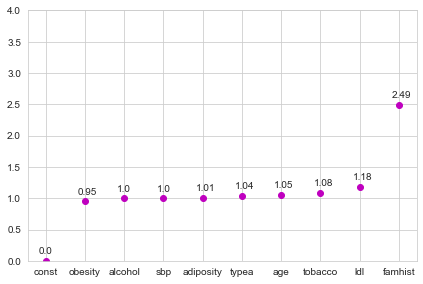

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
values = np.round(np.exp(result0.params).sort_values().values,2)
labels = np.exp(result0.params).sort_values().index

_ = plt.plot(range(len(labels)), values, 'mo') # Plotting data
_ = plt.xticks(range(len(labels)), labels) # Redefining x-axis labels
_ = plt.tight_layout()

for i, v in enumerate(values):
    ax.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')
_ = plt.ylim(0,4)

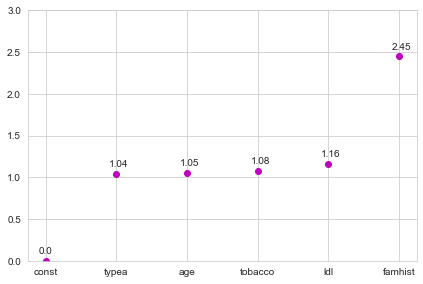

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)
values = np.round(np.exp(result1.params).sort_values().values,2)
labels = np.exp(result1.params).sort_values().index

_ = plt.plot(range(len(labels)), values, 'mo') # Plotting data
_ = plt.xticks(range(len(labels)), labels) # Redefining x-axis labels
_ = plt.tight_layout()

for i, v in enumerate(values):
    ax.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')
_ = plt.ylim(0,3)

Odd' Ratio Give a more deep insight to which variables are most significant

# iv.	Obtain a confusion matrix based on the cut-off probability 0.5 and report precision.

In [65]:
from sklearn.metrics import  classification_report,precision_score
print(classification_report(y_val,logreg.predict(X_val_rs)))
print(precision_score(y_val,logreg.predict(X_val_rs)))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        70
           1       0.65      0.59      0.62        37

    accuracy                           0.75       107
   macro avg       0.72      0.71      0.72       107
weighted avg       0.74      0.75      0.74       107

0.6470588235294118


# (B) Decision Tree

In [66]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
dt = DecisionTreeClassifier()
dtt = DecisionTreeClassifier(max_depth=7,max_leaf_nodes=6)
dt.fit(X_trn_rs,y_trn)

DecisionTreeClassifier()

In [67]:
print("ACCURACY      :",np.round(cross_validate(dtt,X_trn_rs,y_trn,cv=7)['test_score'].mean()*100,2))
print("ROC AUC SCORE :",np.round(cross_val_score(dtt, X_trn_rs, y_trn, scoring="roc_auc", cv = 7).mean()*100,2))

ACCURACY      : 67.03
ROC AUC SCORE : 67.41


In [68]:
train_accuracies = []
test_accuracies = []
for depth in range(1, 7):
  clf = DecisionTreeClassifier(max_depth=depth)
  clf.fit(X_trn_rs, y_trn)
  # create training & test predictions
  train_predictions = clf.predict(X_trn_rs)
  test_predictions = clf.predict(X_val_rs)
  # calculate training & test accuracies
  train_accuracy = accuracy_score(train_predictions, y_trn)
  test_accuracy = accuracy_score(test_predictions, y_val)
  # append accuracies
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

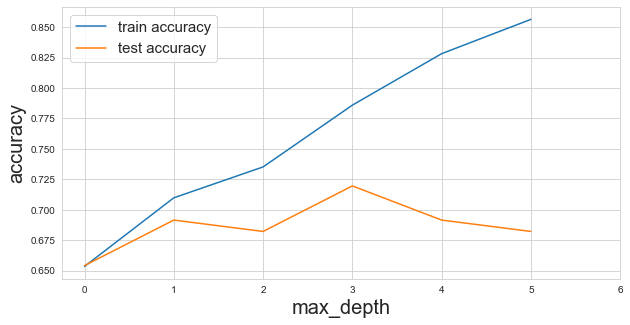

In [69]:
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
plt.plot(train_accuracies, label="train accuracy")
plt.plot(test_accuracies, label="test accuracy")
plt.legend(loc="upper left", prop={'size': 15})
plt.xticks(range(0, 7, 1))
plt.xlabel("max_depth", size=20)
plt.ylabel("accuracy", size=20)
plt.show()

Take 2 as the max depth of the tree

# i.	CART and clearly identify and report predictor which is classifying chd

In [70]:
dt.feature_importances_

array([0.13963846, 0.10021219, 0.11060773, 0.15531119, 0.04666791,
       0.02983962, 0.11192885, 0.13518082, 0.17061323])

In [71]:
X_trn.columns # are the predictors which are classifying the Decision Tree

Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity',
       'alcohol', 'age'],
      dtype='object')

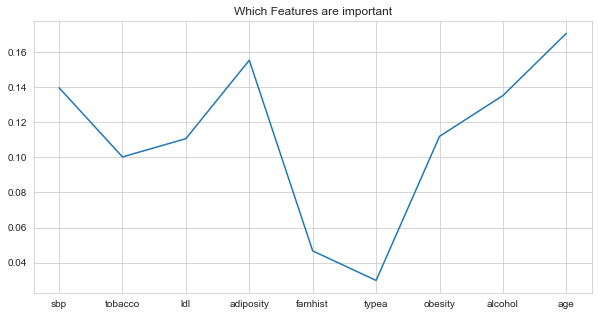

In [72]:
_ = plt.figure(figsize = (10,5))
_ = sns.lineplot(x=X_trn.columns,y=dt.feature_importances_)
_ = plt.title('Which Features are important')

# Random Forests

In [73]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200,random_state=39)
rff = RandomForestClassifier()
rf.fit(X_trn,y_trn)
rf.score(X_val,y_val)

0.6822429906542056

In [74]:
print("ACCURACY      :",np.round(cross_validate(rff,X_trn,y_trn,cv=7)['test_score'].mean()*100,2))
print("ROC AUC SCORE :",np.round(cross_val_score(rff,X_trn,y_trn, scoring="roc_auc", cv = 7).mean()*100,2))

ACCURACY      : 66.48
ROC AUC SCORE : 73.71


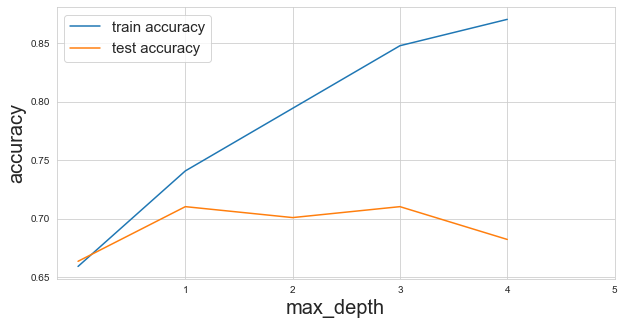

In [75]:
train_accuracies = []
test_accuracies = []
for depth in range(1,6):
  clf = RandomForestClassifier(max_depth=depth)
  clf.fit(X_trn_rs, y_trn)
  # create training & test predictions
  train_predictions = clf.predict(X_trn_rs)
  test_predictions = clf.predict(X_val_rs)
  # calculate training & test accuracies
  train_accuracy = accuracy_score(train_predictions, y_trn)
  test_accuracy = accuracy_score(test_predictions, y_val)
  # append accuracies
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
plt.plot(train_accuracies, label="train accuracy")
plt.plot(test_accuracies, label="test accuracy")
plt.legend(loc=0, prop={'size': 15})
plt.xticks(range(1,6))
plt.xlabel("max_depth", size=20)
plt.ylabel("accuracy", size=20)
plt.show()

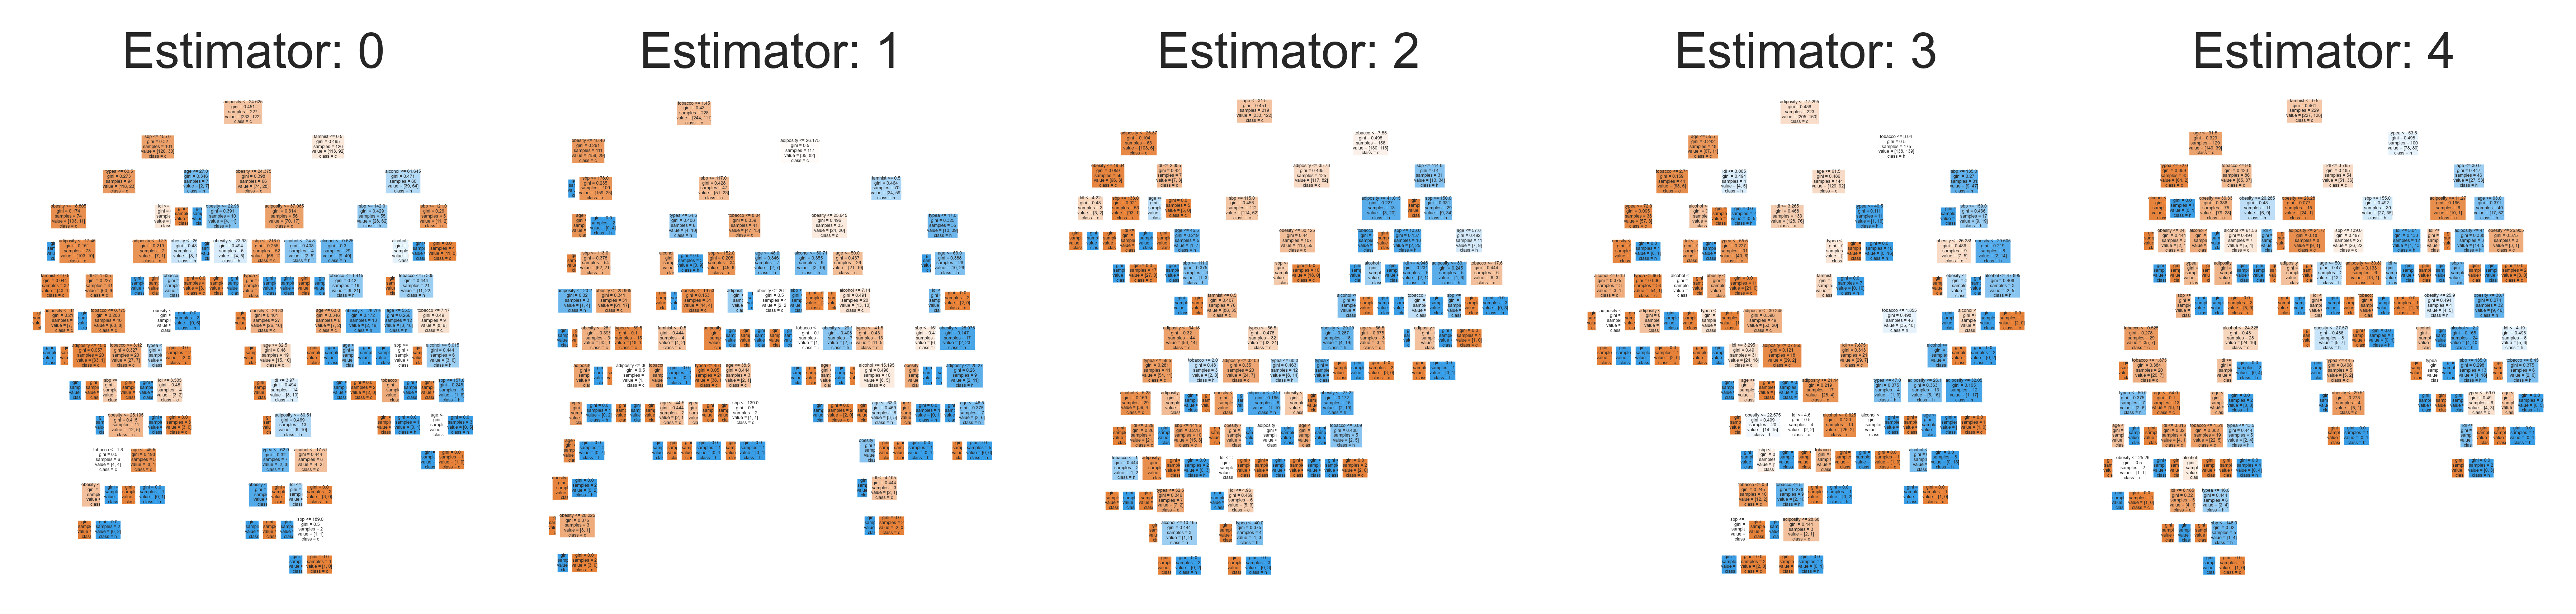

In [76]:
fn=X_trn.columns
cn='chd'
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    plot_tree(rf.estimators_[index],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
#fig.savefig('rf_5trees.png')

 # ii.	Random Forest and clearly identify and report predictor which is classifying chd

In [77]:
rf.feature_importances_

array([0.10988421, 0.15782188, 0.13561891, 0.12118306, 0.04673604,
       0.10280443, 0.09857218, 0.08016972, 0.14720956])

In [78]:
X_trn.columns # the predictors classifying 

Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity',
       'alcohol', 'age'],
      dtype='object')

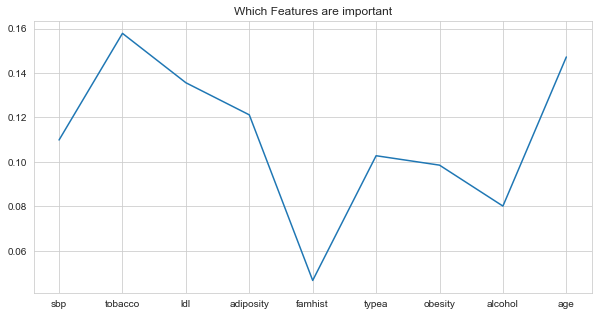

In [79]:
_ = plt.figure(figsize = (10,5))
_ = sns.lineplot(x=X_trn.columns,y=rf.feature_importances_)
_ = plt.title('Which Features are important')

# iii.	Choose the best classifier among (i) and (ii) of (b) by clearly stating the reason of selection. Also plot that decision tree and report the most important splitting criteria .

In [80]:
acc_dt = np.round(cross_validate(dtt,X_trn_rs,y_trn,cv=7)['test_score'].mean()*100,2)
auc_dt = np.round(cross_val_score(dtt, X_trn_rs, y_trn, scoring="roc_auc", cv = 7).mean()*100,2)
DT = list((acc_dt,auc_dt))

acc_rf = np.round(cross_validate(rff,X_trn,y_trn,cv=7)['test_score'].mean()*100,2)
auc_rf = np.round(cross_val_score(rff,X_trn,y_trn, scoring="roc_auc", cv = 7).mean()*100,2)
RF = list((acc_rf,auc_rf))

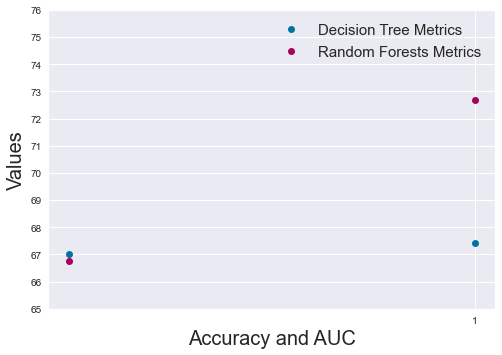

In [110]:
sns.set_style("darkgrid")
_ = plt.plot(DT,'o',label = 'Decision Tree Metrics')
_ = plt.plot(RF,'mo',label = 'Random Forests Metrics')
_ = plt.legend(loc=0, prop={'size': 15})
_ = plt.xticks(range(1,2))
_ = plt.yticks(range(65,77))
_ = plt.xlabel("Accuracy and AUC", size=20)
_ = plt.ylabel("Values", size=20)
plt.show()

We can see that the ensemble method by which Random Forest was created gives us the **upper edge** be it  Accuracy or AUC

The most Important Split made by the Variable is **AGE**, the reason being it is being able to bifurcate the rest of the predictors while having the least impurity

<img src = 'Decision Tree Class.png' width = 10000px>

<img src = 'prec.png' width = 600px>

In [82]:
print(precision_score(y_val,rf.predict(X_val)))

0.5428571428571428


# (c)  Compare the logistic regression model and decision tree classifier performance?

In [83]:
acc_dt = np.round(cross_validate(dtt,X_trn_rs,y_trn,cv=7)['test_score'].mean()*100,2)
auc_dt = np.round(cross_val_score(dtt, X_trn_rs, y_trn, scoring="roc_auc", cv = 7).mean()*100,2)
DT = list((acc_dt,auc_dt))

acc_lr = np.round(cross_validate(logreg,X_trn,y_trn,cv=7)['test_score'].mean()*100,2)
auc_lr = np.round(cross_val_score(logreg,X_trn,y_trn, scoring="roc_auc", cv = 7).mean()*100,2)
LR = list((acc_lr,auc_lr))

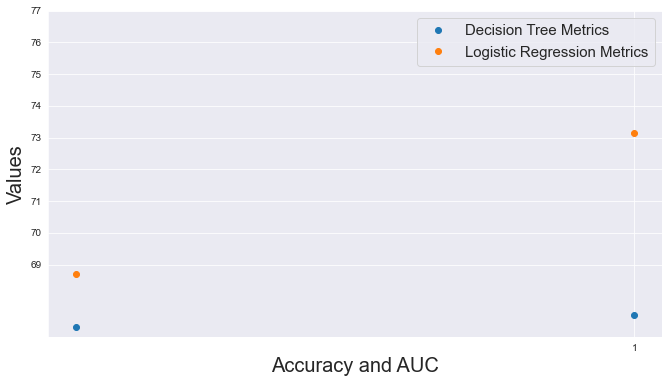

In [84]:
sns.set_style("darkgrid")
_ = plt.figure(figsize=(11,6))
_ = plt.plot(DT,'o',label = 'Decision Tree Metrics')
_ = plt.plot(LR,'o',label = 'Logistic Regression Metrics')
_ = plt.legend(loc=0, prop={'size': 15})
_ = plt.xticks(range(1,2))
_ = plt.yticks(range(69,78))
_ = plt.xlabel("Accuracy and AUC", size=20)
_ = plt.ylabel("Values", size=20)
plt.show()

We can see that the Logistic Regression Classifier is a better model than the Desicion Tree Classifier as the Accuracy and the Area Under the Curve is better than that of Desicion Tree

# Question 3

In [85]:
ipl = pd.read_excel('IPL2013.xlsx',sheet_name=0);ipl.head()

,Sl.NO.,PLAYER NAME,AGE,PLAYING ROLE,T-RUNS-S,T-WKTS,ODI-RUNS-S,ODI-SR-B,ODI-WKTS,ODI-SR-BL,...,AVE-B,SR-B,SIXERS,RUNS-C,WKTS,AVE-BL,ECON,SR-BL,AUCTION YEAR,SOLD PRICE
0,1,"Abdulla, YA",2,Allrounder,0,0,0,0.00,0,0.0,...,0.00,0.00,0,307,15,20.47,8.90,13.93,2009,50000
1,2,Abdur Razzak,2,Bowler,214,18,657,71.41,185,37.6,...,0.00,0.00,0,29,0,0.00,14.50,0.00,2008,50000
2,3,"Agarkar, AB",2,Bowler,571,58,1269,80.62,288,32.9,...,18.56,121.01,5,1059,29,36.52,8.81,24.90,2008,350000
3,4,"Ashwin, R",1,Bowler,284,31,241,84.56,51,36.8,...,5.80,76.32,0,1125,49,22.96,6.23,22.14,2011,850000
4,5,"Badrinath, S",2,Batsman,63,0,79,45.93,0,0.0,...,32.93,120.71,28,0,0,0.00,0.00,0.00,2011,800000


In [86]:
X = ipl.drop(['Sl.NO.','PLAYER NAME',"SOLD PRICE"],axis = 1);X.head() 

,AGE,PLAYING ROLE,T-RUNS-S,T-WKTS,ODI-RUNS-S,ODI-SR-B,ODI-WKTS,ODI-SR-BL,CAPTAINCY EXP,RUNS-S,HS,AVE-B,SR-B,SIXERS,RUNS-C,WKTS,AVE-BL,ECON,SR-BL,AUCTION YEAR
0,2,Allrounder,0,0,0,0.00,0,0.0,0,0,0,0.00,0.00,0,307,15,20.47,8.90,13.93,2009
1,2,Bowler,214,18,657,71.41,185,37.6,0,0,0,0.00,0.00,0,29,0,0.00,14.50,0.00,2008
2,2,Bowler,571,58,1269,80.62,288,32.9,0,167,39,18.56,121.01,5,1059,29,36.52,8.81,24.90,2008
3,1,Bowler,284,31,241,84.56,51,36.8,0,58,11,5.80,76.32,0,1125,49,22.96,6.23,22.14,2011
4,2,Batsman,63,0,79,45.93,0,0.0,0,1317,71,32.93,120.71,28,0,0,0.00,0.00,0.00,2011


In [87]:
y = np.log(ipl['SOLD PRICE']/1e5)

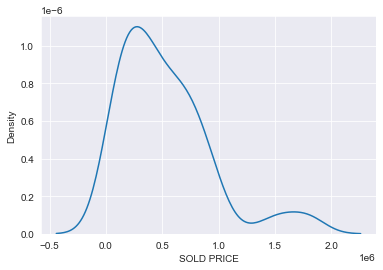

In [88]:
_ = sns.kdeplot((np.exp(y)*1e5)) #Distn is slight Bi Modal,might Hamper Predictions

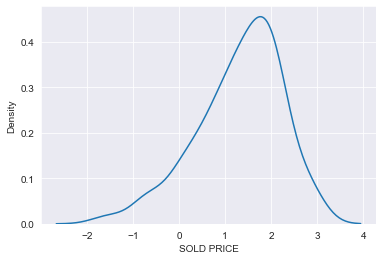

In [89]:
_ = sns.kdeplot(y) #Applying Log Transformation we get a smooth almost normal curve which brings down the RMSE

In [90]:
X_trn,X_val,y_trn,y_val = train_test_split(X,y,test_size = .2)

In [91]:
le = sklearn.preprocessing.LabelEncoder()

X_trn.loc[:,'PLAYING ROLE'] = le.fit_transform(X_trn['PLAYING ROLE'])

X_val.loc[:,'PLAYING ROLE'] = le.transform(X_val['PLAYING ROLE'])

In [92]:
rs = RobustScaler()

X_trn_rs = rs.fit_transform(X_trn)

X_val_rs = rs.transform(X_val)

In [93]:
from sklearn.linear_model import LinearRegression
linr = LinearRegression()

In [94]:
-cross_validate(linr,X_trn,y_trn,scoring='neg_mean_squared_error')['test_score'].mean()

0.7437326889119446

## i.	Which features have the symptom of multicollinearity and need to be removed from the model?

In [95]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def give_VIF(X):
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  return (vif)

In [96]:
give_VIF(X_trn).sort_values(by  = 'VIF')

,variables,VIF
1,PLAYING ROLE,3.795400
8,CAPTAINCY EXP,4.007393
7,ODI-SR-BL,4.525807
17,ECON,6.809472
13,SIXERS,7.372776
3,T-WKTS,7.893521
6,ODI-WKTS,9.520780
2,T-RUNS-S,11.374425
9,RUNS-S,12.126606
5,ODI-SR-B,13.911996


In [97]:
give_VIF(pd.DataFrame(X_trn_rs,columns = X_trn.columns)).sort_values('VIF')

,variables,VIF
1,PLAYING ROLE,1.531938
7,ODI-SR-BL,1.742408
19,AUCTION YEAR,1.928050
5,ODI-SR-B,1.972355
0,AGE,2.038205
12,SR-B,2.572382
17,ECON,3.060592
8,CAPTAINCY EXP,3.426992
11,AVE-B,5.951521
13,SIXERS,6.154329


We see that VIF takes a major **HIT** when we standardize the feature matrix

In [112]:
viff = pd.DataFrame(X_trn_rs,columns=X_trn.columns)

In [99]:
XX = X.copy()
XX.loc[:,'PLAYING ROLE'] = le.fit_transform(XX['PLAYING ROLE'])
XX = rs.fit_transform(XX)
XX = pd.DataFrame(XX,columns=X.columns)
XX.head()

,AGE,PLAYING ROLE,T-RUNS-S,T-WKTS,ODI-RUNS-S,ODI-SR-B,ODI-WKTS,ODI-SR-BL,CAPTAINCY EXP,RUNS-S,HS,AVE-B,SR-B,SIXERS,RUNS-C,WKTS,AVE-BL,ECON,SR-BL,AUCTION YEAR
0,0.0,-0.5,-0.182246,-0.147368,-0.242011,-3.700331,-0.174528,-0.807501,0.0,-0.194076,-0.614719,-1.032553,-3.839624,-0.208696,0.014509,0.273684,-0.121276,0.184298,-0.229089,0.333333
1,0.0,0.5,-0.110355,0.231579,-0.051590,-0.322375,1.570755,0.022063,0.0,-0.194076,-0.614719,-1.032553,-3.839624,-0.208696,-0.388828,-0.357895,-0.696599,0.863292,-0.760515,0.000000
2,0.0,0.5,0.009574,1.073684,0.125788,0.113292,2.542453,-0.081633,0.0,-0.005642,0.060606,-0.004156,0.080998,-0.034783,1.105550,0.863158,0.329820,0.173386,0.189413,0.000000
3,-1.0,0.5,-0.086840,0.505263,-0.172161,0.299669,0.306604,0.004413,0.0,-0.128632,-0.424242,-0.711179,-1.366920,-0.208696,1.201306,1.705263,-0.051293,-0.139436,0.084120,1.000000
4,0.0,0.0,-0.161082,-0.147368,-0.219115,-1.527673,-0.174528,-0.807501,0.0,1.291961,0.614719,0.792076,0.071278,0.765217,-0.430903,-0.357895,-0.696599,-0.894817,-0.760515,1.000000


Features  Left  after  removing  Multicollinearity

In [100]:
vif_XX

NameError: name 'vif_XX' is not defined

In [111]:
_ = plt.figure(figsize=(14,5))
_ = sns.lineplot('variables','VIF',data = vif_XX)
_ = plt.tight_layout()
_ = plt.axhline(y=4,color = 'r',linestyle = '--' )

NameError: name 'vif_XX' is not defined

<Figure size 1008x360 with 0 Axes>

In [ ]:
vif_drop = vif_XX.variables.values;vif_drop

In [ ]:
final_XX = XX[vif_drop]
-cross_validate(linr,final_XX,y,scoring='neg_mean_squared_error')['test_score'].mean()
#As we see the RMSE has dropped from 1.1247 to .7261

## ii.	Find outliers in the dataset using Cook’s distance and standardized residuals. If required remove and report the observations from the dataset.

In [ ]:
final_XX['sold_price'] = y;final_XX.head()

In [ ]:
final_XX.columns = final_XX.columns.str.replace(' ', '_')
final_XX.columns = final_XX.columns.str.replace('-', '_')

In [ ]:
final_XX.head()

In [ ]:
from statsmodels.formula.api import ols

m = ols('y ~ AGE	+PLAYING_ROLE	+T_RUNS_S	+T_WKTS	+ODI_SR_B	+ODI_SR_BL	+CAPTAINCY_EXP	+AVE_B	+SR_B	+SIXERS	+RUNS_C+AVE_BL+ECON	+AUCTION_YEAR',final_XX).fit()
infl = m.get_influence()
sm_fr = infl.summary_frame()
sm_fr['cooks_d'] 

In [101]:
_ = plt.plot(sm_fr['cooks_d'],) 
_ = plt.axhline(y=1,color = 'r',linestyle = '--' ) 

NameError: name 'sm_fr' is not defined

As we see no tuple exceed the cook's Distance

## iii.	What are the assumptions to be validated in a linear regression model?

#### The residuals should be randomly scattered and give a bayesian distribution, very much like in the figure below.
#### Which satisfies the assumption of the normality of the residuals.

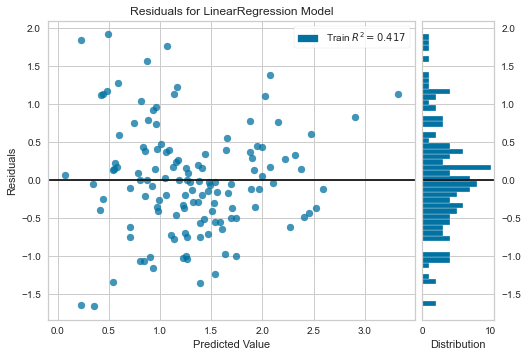

In [102]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate and fit the visualizer
model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
_ = visualizer_residuals.fit(XX, y)
_ = visualizer_residuals.show()

#### The Dep and Indep must have Linear Relationship

In [103]:
final_XX.columns

NameError: name 'final_XX' is not defined

In [ ]:
final_XX.columns

In [ ]:
for i, col in enumerate(final_XX.columns):
    plt.figure(i)
    sns.scatterplot(x=col,y = 'sold_price', data=final_XX)

 We see that many do not have a linear relationship with the targert variable the two reasons for that are firstly,
qualitative variables like age when Lable Encoded with give only a set of Integer values which in no way will be linear.
For the rest we can transform the data like taking the sqaure root, taking the log transformation, taking the sqaure et cetera

### No Autocorrelation in Residuals

In [ ]:
X_poly = sm.add_constant(XX)
res = sm.OLS(y,X_poly).fit()
print(res.summary())

In [ ]:
# another assumption is that the residuals should not have Autocorrelation here we see that Durbin-Watson: gives us 2.001
#which is almost ideal value for no autocorrelation

### No Heteroskedasticity.

In [ ]:
#funnel shape would be seen in the scatter plot of RESIDUALS and FITTED VALUES

<img src  = 'hetero.jpg' width = 300px>

In [ ]:
preds = cross_val_predict(linr,X_val_rs,y_val)

In [ ]:
_ = plt.figure(figsize=(5,4))
_ = plt.scatter(preds-(y_val),preds)
_ = plt.title('Heteroskedasticity PRESENT')

In [ ]:
#usually transforming the target variable works,here I had already taken Log transformation before so I'm taking exp to take 
#original target values

In [ ]:
_ = plt.figure(figsize=(5,4))
_ = plt.scatter(preds-np.exp(y_val),preds)
_ = plt.title('Heteroskedasticity REMOVED')

### No Multicollinearity

In [ ]:
# we have already dealt with this usinf VIF Variance Inflation factor

<img src  = 'vif.png' width = 450px>

In [104]:
# we have also removed the neccesary features that had VIF

### vi.	Which features are statistically significant in predicting the SOLD PRICE of a player?

In [105]:
print(sm.OLS(y,final_XX,random_state=0).fit().summary())

NameError: name 'final_XX' is not defined

In [106]:
final_xxx = final_XX
#final_xxx.drop('sold_price',axis = 1,inplace = True)
final_xxx = sm.add_constant(final_xxx)
final_xxx.head()

NameError: name 'final_XX' is not defined

Below Code automatically detects p values greater than 0.05 and removes them and does this step by step

In [107]:
for _ in range(14):
  model=sm.OLS(y,final_xxx,random_state=0)
  result=model.fit()
  print(result.summary())
  p = pd.DataFrame(result.pvalues)
  p.columns = ['p_vals']
  shit = np.argmax(p['p_vals'])
  #print(shit,max((p['p_vals']))) 
  #XX_trn = XX_trn.drop([shit],axis = 1)
  final_xxx = final_xxx.drop(final_xxx.columns[shit], axis=1)
  if max(p.values) < .051:
    break

NameError: name 'final_xxx' is not defined

In [108]:
print('Significant Feature which determine Sold Price',final_xxx.columns.values)

NameError: name 'final_xxx' is not defined

### vii.	Build a linear regression model with significant features and report model performance

In [ ]:
print('RMSE',(np.exp(cross_val_score(linr,final_xxx,y,scoring='neg_mean_squared_error'))).mean()) #lowest RMSE till now

### viii.	Predict the SOLD PRICE of players using the test data using the model fitted

In [ ]:
np.exp(cross_val_predict(linr,final_xxx,y))*1e5